In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
import os
import fit_library as ft
import open_data
import h5py

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def analyze2(DATA,channel=1,Low_th=-100,High_th=10000,bins='sqrt',mu1=168,mu2=168,sigma=2):
    Q_fit = ft.gauss_fit2()
    data_fit = DATA[(DATA > Low_th) & (DATA < High_th)]
    print(data_fit.shape)
    Q_fit(data_fit,[mu1,mu2,sigma,sigma],bins)
    fig = plt.figure()
    ax0 = fig.add_subplot(111)
    Q_fit.plot(axis = ax0, 
               title = "Channel 1 - QDC",
               xlabel = "Code (LSB)",ylabel = "Hits")

    
def analyze(axis,DATA,Low_th=-100,High_th=10000,bins='sqrt',
            graph_title="",x_axis="",text_pos=[0.95,0.95,'right']):
    Q_fit = ft.gauss_fit()
    data_fit_i = DATA[(DATA > Low_th) & (DATA < High_th)]
    #print("MINIMO",np.min(data_fit_i))
    #print("MAXIMO",np.max(data_fit_i))
    
    # Find limits
    hist,bins_e = np.histogram(data_fit_i, bins=1000)
    hits = np.sum(hist)
    L2R = np.cumsum(hist)
    R2L = np.cumsum(hist[::-1])
    #high_limit = bins_e[np.argmax(L2R > 0.9999*hits)]
    #low_limit  = bins_e[len(bins_e)-np.argmax(R2L > 0.9999*hits)]
    #data_fit = DATA[(DATA > low_limit-1) & (DATA < high_limit+1)]    
    data_fit = DATA[(DATA > Low_th) & (DATA < High_th)]
    
    Q_fit(data_fit,bins)
    Q_fit.plot(axis = axis, 
               title = graph_title,
               xlabel = x_axis,ylabel = "Hits",res=True,text_pos=text_pos)

    
def QDC_TDC(DATA,channel,GQ1=1,GQ2=1,Q_offset=0):
    # Default time units = 1 ns
    # Default CLK = 200 MHz -> Default TDC_CLK = 100 MHz (TDC_T = 10 ns)
    # TDC works for 2 x TDC_CLK at maximum (that would be TDC input full scale). TDC resolution = 10bits    
    n_bits = 10
    TDC_T  = 10.0
    I_integbias = 1
       
    # Following Data-sheet style
    
    t_coarse = np.array(DATA['tcoarse'][(DATA['channel_id']==channel)])
    q_coarse = np.array(DATA['ecoarse'][(DATA['channel_id']==channel)])
 
    # Wrap around game - see TOFPET decoder
    t_fine   = ( np.array(DATA['tfine'][(DATA['channel_id']==channel)]) + 27 ) % (2**n_bits)
    q_fine   = ( np.array(DATA['efine'][(DATA['channel_id']==channel)]) + 27 ) % (2**n_bits)
    
    t_fine_min = np.min(t_fine)
    t_fine_max = np.max(t_fine)
    t_fine_b   = TDC_T/(t_fine_max - t_fine_min)
    t_fine_a   = t_fine_min-TDC_T/t_fine_b    
    
    
    t_T      = (t_coarse)*TDC_T - (t_fine-t_fine_a)*t_fine_b
    #Global Timestamp
    t_T_10bits = (t_coarse % 2**n_bits)*TDC_T - (t_fine-t_fine_a)*t_fine_b
    
    time_window_fine = q_coarse*TDC_T - t_T_10bits
    q_correction = I_integbias*GQ2*time_window_fine/TDC_T - Q_offset

    return (q_fine-q_correction)/(GQ1*GQ2), t_fine, q_coarse-(t_coarse % 2**n_bits), time_window_fine, (t_fine-t_fine_a)*t_fine_b, q_fine


def TDC_calibration(df,channel,TAC):
    

2641.2984812730683


<IPython.core.display.Javascript object>


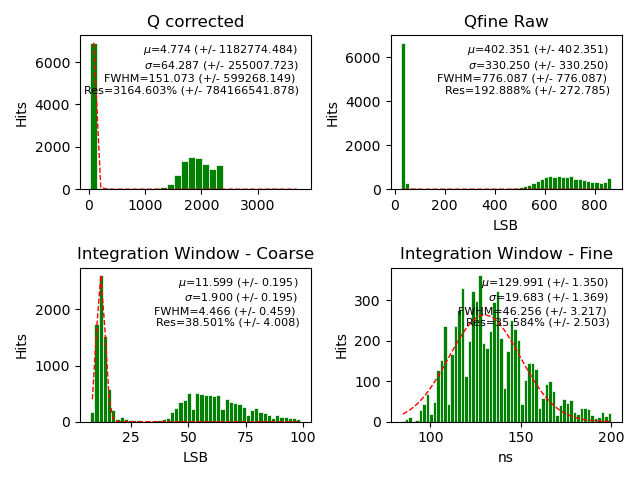

Fitting Problems


<IPython.core.display.Javascript object>


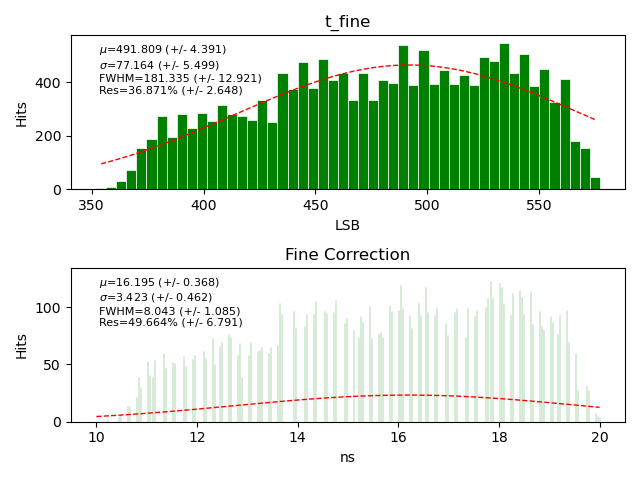

In [3]:
CHANNEL = 57
#RUN = 9029 # LED = 2.2 V
#RUN = 9028 # LED = 2.3 V
#RUN = 9030 # LED = 0 V (Darkcount) 
#RUN = 9042 2 # LED = 1.985 V (Very low light)
#RUN = 9044 # LED = 1.985 V (Very low light) 45-41-50
RUN = 9084
#9058 - 90.9
#9059 - 102.7
#9063 - 123.5
#9064 - 156.8
#9065 - 215.5
#9066 - 308.8
#9067 - 435.9
#9068 - 599.6
#9069 - 926.6
#9070 - 1632.5
n_files = 1

filename = "/home/viherbos/DATA_daq/run_" + str(RUN) + "_0000_trigger1_waveforms.h5"
data = pd.read_hdf(filename,key='data')
    
for i in range(1,n_files):
    print(i)
    filename = "/home/viherbos/DATA_daq/run_" + str(RUN) + "_000"+str(i)+"_trigger1_waveforms.h5"
    data = pd.concat([data, pd.read_hdf(filename,key='data')], ignore_index=True)

out = QDC_TDC(data,CHANNEL,GQ1=0.32,GQ2=1,Q_offset=0)
print(np.mean(out[2]))

fig, axs = plt.subplots(2, 2)
analyze(axs[0,0],out[0],0,4000,30,"Q corrected","",text_pos=[0.95,0.95,'right'])
analyze(axs[0,1],out[5],0,1024,50,"Qfine Raw","LSB")
analyze(axs[1,0],out[2],-10,100,50,"Integration Window - Coarse", "LSB")
analyze(axs[1,1],out[3],0,200,60,"Integration Window - Fine", "ns")
fig.tight_layout()

fig2, axs2 = plt.subplots(2, 1)
analyze(axs2[1],out[4],-30,50,1000,"Fine Correction","ns",text_pos=[0.05,0.95,'left'])
analyze(axs2[0],out[1],0,1024,50,"t_fine","LSB",text_pos=[0.05,0.95,'left'])
fig2.tight_layout()

In [6]:
data[data.tac_id==0]

,evt_number,tofpet_id,wordtype_id,channel_id,tac_id,tcoarse,ecoarse,tfine,efine
1,2,0,2,57,0,7651,492,540,5
15,10,0,2,57,0,32312,644,469,754
18,12,0,2,57,0,43652,696,368,579
19,13,0,2,57,0,49321,247,453,762
22,15,0,2,57,0,60661,322,477,761
...,...,...,...,...,...,...,...,...,...
16500,9573,0,2,57,0,38651,824,421,648
16505,9575,0,2,57,0,25942,356,471,6
16510,9577,0,2,57,0,56622,316,415,6
16519,9583,0,2,57,0,50763,600,411,1


## CALIBRATION

#Calibration
channel = 57

filename3 = "/home/viherbos/DATA_daq/run_8994_0000_trigger1_waveforms.h5"

data = pd.read_hdf(filename3,key='counter')
count = np.array(data['count'][data['channel_id']==channel])
print(count[0],(2**20-1))
analyze(count,Low_th=0,High_th=2**24)

In [401]:
filename = "/home/viherbos/DATA_daq/tfine_calibration.h5"
data = pd.read_hdf(filename)

In [450]:
canal = 45
tac   = 0
datos = data[(data.tac==tac)&(data.channel==canal)]


Value os CHISQR = 2.827784


<IPython.core.display.Javascript object>


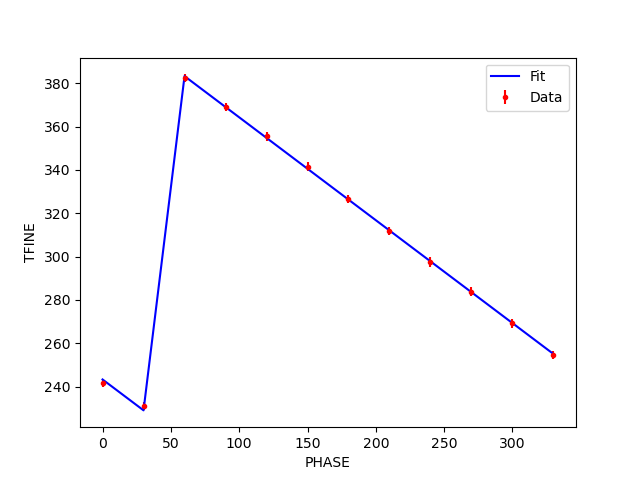

In [452]:
Q_fit = ft.fitting_nohist()
amplitude = -82
period    = 360
shift     = 40
offset    = 280


coeff  = [amplitude,period,shift,offset]
bounds = [[-200,350,   0,   0],
          [   0,360,  50, 350]]

Q_fit(datos.eval("mean"),datos.phase,ft.sawtooth,
      [amplitude,period,shift,offset],bounds)
chisq = np.sum(((datos.eval("mean")-Q_fit.evaluate(datos.phase))/datos.sigma)**2)
print("Value os CHISQR = %f" % chisq)

plt.figure()
plt.plot(datos.phase,Q_fit.evaluate(datos.phase),'b-',label="Fit")
#plt.plot(datos.phase,ft.sawtooth(datos.phase,*coeff),'g-*')
#plt.plot(datos.phase,datos.eval("mean"),'r-o',label="Data")
plt.errorbar(datos.phase,datos.eval("mean"), datos.sigma,
             fmt='.',color='red',label="Data")
plt.xlabel("PHASE")
plt.ylabel("TFINE")
plt.legend()

<IPython.core.display.Javascript object>


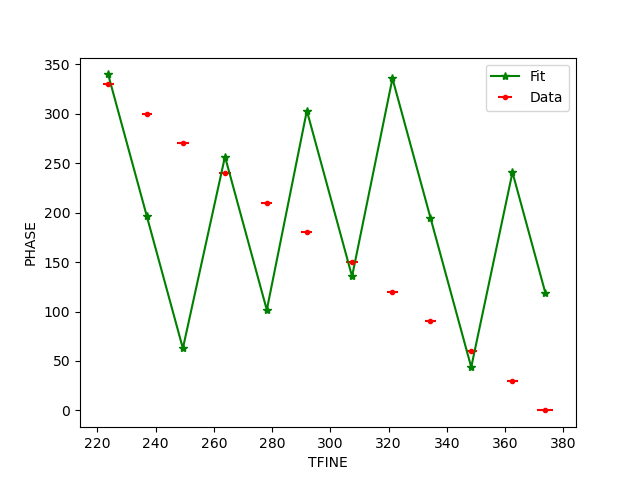

In [448]:
plt.figure()
#plt.plot(datos.eval("mean"),datos.phase,'b-o',label="Data")
plt.errorbar(datos.eval("mean"),datos.phase, xerr=datos.sigma,
             fmt='.',color='red',label="Data")
plt.ylabel("PHASE")
plt.xlabel("TFINE")
inverse = ft.sawtooth_inv(datos.eval("mean"),*Q_fit.coeff)
inverse[inverse<0]=inverse[inverse<0]+Q_fit.coeff[1]                          
plt.plot(datos.eval("mean"),inverse,'g-*',label="Fit")
plt.legend()